# ES Pattern Detection

## 1. Project overview and objectives

### 1.1 Context and data source

- Data source: ENTSO-E day ahead prices for the ES bidding zone.  
- Preprocessing: The raw hourly data has already been cleaned and aggregated into a daily dataset named `ES_preprocessed.csv`.  
- Each row corresponds to one calendar day and contains:
  - A `date` column.
  - 24 hourly price columns `h00` to `h23` in EUR/MWh.

### 1.2 Goal of this notebook

The goal of this notebook is to identify typical daily price profile regimes and how these regimes evolve over the calendar.  
We will cluster daily price profiles and then plot the cluster assignment in a calendar view for each year.

### 1.3 High level pipeline

1. Load the preprocessed ES daily data.  
2. Run a few core checks and a compact exploratory analysis.  
3. Select the time horizon of interest for the clustering.  
4. Build a feature matrix of daily price vectors (24 hours).  
5. Apply hierarchical clustering with Ward linkage.  
6. Decide on the number of clusters based on the dendrogram and merge distances.  
7. Assign clusters and interpret the resulting typical daily profiles.  
8. Plot yearly calendar maps that show which cluster each day belongs to.


## 2. Setup and path configuration

In this section we load all required libraries and configure the paths that point to the preprocessed ES data.

### 2.1 Import libraries

We import the scientific Python stack and plotting libraries:

- `numpy` and `pandas` for data handling.  
- `matplotlib` for plotting.  
- `scipy.cluster.hierarchy` for hierarchical clustering.  
- `pathlib.Path` for robust path handling.

### 2.2 Define base paths and data locations

We assume that this notebook lives inside a `notebooks` directory of the project.  
From the current working directory we construct:

- `NOTEBOOKS_DIR`: directory that contains the notebooks.  
- `PROJECT_ROOT`: project root one level above `notebooks`.  
- `PREPROCESSING_DATA_DIR`: directory that contains the cleaned ES daily data.  
- `ES_CSV_PATH`: full path to `ES_preprocessed.csv`.

### 2.3 Global plotting configuration

We apply a consistent plotting style and set some global defaults for figure size and layout.


In [1]:
# 2. Setup and path configuration

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.colors import ListedColormap, BoundaryNorm

# Use a clean plotting style
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

# 2.2 Path configuration

# Assume the notebook is executed from the notebooks directory or a subdirectory.
NOTEBOOKS_DIR = Path.cwd()
if NOTEBOOKS_DIR.name != "notebooks":
    NOTEBOOKS_DIR = NOTEBOOKS_DIR.parent

PROJECT_ROOT = NOTEBOOKS_DIR.parent

PREPROCESSING_DATA_DIR = (
    PROJECT_ROOT
    / "notebooks"
    / "02_preprocessing"
    / "data"
    / "clean"
)

ES_CSV_PATH = PREPROCESSING_DATA_DIR / "ES_preprocessed.csv"

print("Notebook dir:          ", NOTEBOOKS_DIR)
print("Project root:          ", PROJECT_ROOT)
print("Preprocessing data dir:", PREPROCESSING_DATA_DIR)
print("ES CSV path:           ", ES_CSV_PATH)


Notebook dir:           /home/jovyan/my-notebooks/Data Science Lab/data
Project root:           /home/jovyan/my-notebooks/Data Science Lab
Preprocessing data dir: /home/jovyan/my-notebooks/Data Science Lab/notebooks/02_preprocessing/data/clean
ES CSV path:            /home/jovyan/my-notebooks/Data Science Lab/notebooks/02_preprocessing/data/clean/ES_preprocessed.csv


## 3. Data loading and core structure validation

In this section we load the preprocessed ES daily dataset and run the minimum structural checks that are required for clustering.

### 3.1 Load ES preprocessed daily dataset

- Read `ES_preprocessed.csv` from disk.  
- Print the shape of the dataset.  
- Show the first rows for a quick sanity check.

### 3.2 Column overview and data types

- List all column names.  
- Show the data types of all columns.

### 3.3 Date column validation and conversion

- Check that a `date` column exists.  
- Convert `date` to timezone aware `datetime` (UTC) if needed.  
- Sort the dataset by `date` and reset the index.  
- Print the minimal and maximal date and the number of rows.

### 3.4 Identification of hourly price columns

- Identify hourly price columns using the prefix `h`.  
- Ensure that there are exactly 24 hourly columns.  
- Make sure these columns are numeric and convert them if necessary.

### 3.5 Duplicate dates check

- Check whether there are duplicated dates.  
- Report how many rows have duplicated dates and show examples if any exist.


In [2]:
# 3. Data loading and core structure validation

# 3.1 Load ES preprocessed daily dataset
if not ES_CSV_PATH.exists():
    raise FileNotFoundError(
        "Could not find ES_preprocessed dataset.\n"
        f"Expected CSV file at:\n{ES_CSV_PATH}"
    )

print(f"Loading ES preprocessed data from: {ES_CSV_PATH}")
es_df = pd.read_csv(ES_CSV_PATH)

print("\nRaw ES_preprocessed dataset loaded.")
print("Shape (rows, columns):", es_df.shape)
display(es_df.head())

# 3.2 Column overview and data types
print("\nColumn names:")
print(list(es_df.columns))

print("\nData types:")
print(es_df.dtypes)

# 3.3 Date column validation and conversion
if "date" not in es_df.columns:
    raise ValueError(
        "Expected a 'date' column in ES_preprocessed, but it was not found."
    )

if not np.issubdtype(es_df["date"].dtype, np.datetime64):
    es_df["date"] = pd.to_datetime(es_df["date"], utc=True)

es_df = es_df.sort_values("date").reset_index(drop=True)

min_date = es_df["date"].min()
max_date = es_df["date"].max()

print(f"\nDate range from {min_date} to {max_date}")
print("Number of rows (days):", es_df.shape[0])

# 3.4 Identification of hourly price columns
hour_cols = [col for col in es_df.columns if col.startswith("h")]

print("\nDetected hourly columns:")
print(hour_cols)

if len(hour_cols) != 24:
    raise ValueError(
        f"Expected 24 hourly columns (h00 to h23), "
        f"but detected {len(hour_cols)} columns: {hour_cols}"
    )

for col in hour_cols:
    if not np.issubdtype(es_df[col].dtype, np.number):
        print(f"Converting column '{col}' to numeric.")
        es_df[col] = pd.to_numeric(es_df[col], errors="coerce")

# 3.5 Duplicate dates check
duplicates_mask = es_df["date"].duplicated(keep=False)
n_duplicates = duplicates_mask.sum()

print(f"\nNumber of rows with duplicated dates: {n_duplicates}")

if n_duplicates > 0:
    print("First duplicated dates:")
    display(es_df.loc[duplicates_mask].head())


Loading ES preprocessed data from: /home/jovyan/my-notebooks/Data Science Lab/notebooks/02_preprocessing/data/clean/ES_preprocessed.csv

Raw ES_preprocessed dataset loaded.
Shape (rows, columns): (3651, 25)


,date,h00,h01,h02,h03,h04,h05,h06,h07,h08,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
0,2015-11-29,48.50,44.00,41.75,41.15,40.52,40.86,41.75,42.65,42.65,...,46.65,44.39,45.23,52.63,63.41,66.24,66.52,66.24,63.80,59.00
1,2015-11-30,53.50,44.70,42.76,42.63,42.65,43.39,48.50,62.57,63.69,...,62.57,63.32,64.16,67.51,72.89,75.00,74.49,71.01,66.52,63.39
2,2015-12-01,66.17,61.57,56.70,54.50,53.96,56.70,62.69,69.37,68.00,...,64.76,64.76,65.23,66.50,72.50,72.58,72.07,68.80,65.23,63.29
3,2015-12-02,68.88,62.17,54.21,48.80,48.50,48.69,59.64,68.02,70.00,...,66.52,66.40,67.00,71.00,78.69,77.10,76.99,73.85,67.65,65.98
4,2015-12-03,63.44,51.85,49.78,48.50,48.50,48.53,51.60,64.94,65.65,...,60.66,60.69,62.29,66.03,71.22,73.37,73.91,71.12,66.52,64.60



Column names:
['date', 'h00', 'h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

Data types:
date     object
h00     float64
h01     float64
h02     float64
h03     float64
h04     float64
h05     float64
h06     float64
h07     float64
h08     float64
h09     float64
h10     float64
h11     float64
h12     float64
h13     float64
h14     float64
h15     float64
h16     float64
h17     float64
h18     float64
h19     float64
h20     float64
h21     float64
h22     float64
h23     float64
dtype: object

Date range from 2015-11-29 00:00:00+00:00 to 2025-11-26 00:00:00+00:00
Number of rows (days): 3651

Detected hourly columns:
['h00', 'h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

Number of rows with duplicated dates: 0


## 4. High level exploratory data analysis

We now perform a compact exploratory analysis to understand the overall price history and distribution.  
This step is intentionally short because the main focus of the notebook is on clustering.

### 4.1 ES price history plot

- Compute the daily mean price over the 24 hours for each day.  
- Plot the daily mean price over time.  
- This gives a quick visual overview similar to a ten year history plot.

### 4.2 Summary statistics table

- Use all hourly price values as the base for descriptive statistics.  
- Report:
  - number of observations  
  - mean  
  - standard deviation  
  - median  
  - minimum  
  - maximum  
  - range

### 4.3 Distribution overview and technical bounds

- Plot a histogram of all hourly prices.  
- Define conservative technical bounds for prices (for example between -500 and 500 EUR/MWh).  
- Report how many hourly values fall outside these bounds.  
- At this point we only report the counts and do not filter any rows yet.


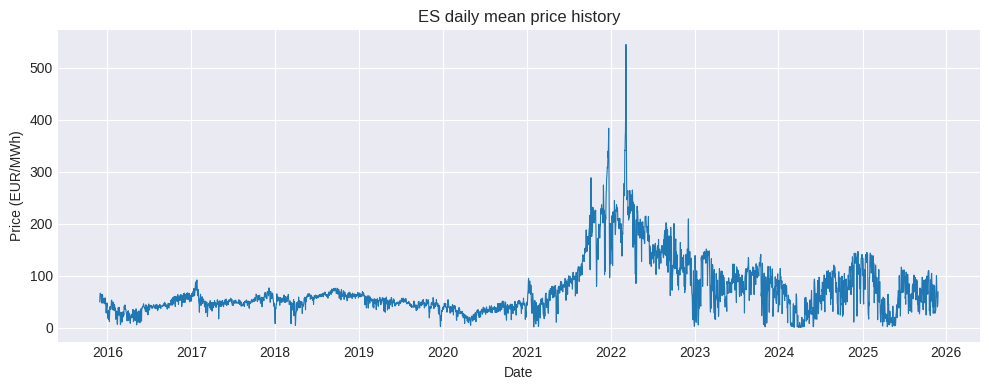


Summary statistics of hourly ES prices:


,n,mean,sd,median,min,max,range
price,87624,72.311318,56.585328,54.99,-15.0,700.0,715.0


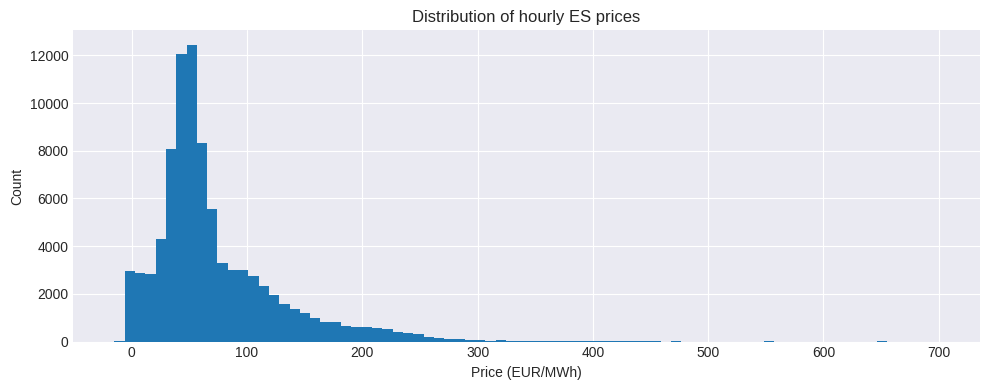


Number of hourly values outside [-500.0, 500.0] EUR/MWh: 26


In [3]:
# 4. High level exploratory data analysis

# Flatten all hourly values into one vector
price_values = es_df[hour_cols].to_numpy().ravel()

# 4.1 ES price history plot based on daily mean price
es_df["daily_mean_price"] = es_df[hour_cols].mean(axis=1)

plt.figure()
plt.plot(es_df["date"], es_df["daily_mean_price"], linewidth=0.8)
plt.title("ES daily mean price history")
plt.xlabel("Date")
plt.ylabel("Price (EUR/MWh)")
plt.tight_layout()
plt.show()

# 4.2 Summary statistics table for hourly prices
n = price_values.size
mean_val = float(np.mean(price_values))
std_val = float(np.std(price_values, ddof=1))
median_val = float(np.median(price_values))
min_val = float(np.min(price_values))
max_val = float(np.max(price_values))
range_val = max_val - min_val

summary_table = pd.DataFrame(
    {
        "n": [n],
        "mean": [mean_val],
        "sd": [std_val],
        "median": [median_val],
        "min": [min_val],
        "max": [max_val],
        "range": [range_val],
    },
    index=["price"],
)

print("\nSummary statistics of hourly ES prices:")
display(summary_table)

# 4.3 Distribution overview and technical bounds
plt.figure()
plt.hist(price_values, bins=80)
plt.title("Distribution of hourly ES prices")
plt.xlabel("Price (EUR/MWh)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

lower_bound = -500.0
upper_bound = 500.0

n_outside_bounds = np.logical_or(
    price_values < lower_bound, price_values > upper_bound
).sum()

print(
    f"\nNumber of hourly values outside "
    f"[{lower_bound}, {upper_bound}] EUR/MWh: {n_outside_bounds}"
)


## 5. Time horizon selection for clustering

It is often useful to restrict the clustering to the most recent years instead of the full history.  
In this section we control the time window through a single parameter.

### 5.1 YEARS_BACK parameter

- `YEARS_BACK = None`  
  The full available history is used for clustering.  
- `YEARS_BACK = k` (for example `3`)  
  Only the last `k` calendar years are kept for clustering.

### 5.2 Filter ES dataset to selected years

- Derive the calendar year from the `date` column.  
- Determine the minimal and maximal available year.  
- Compute the earliest year to keep based on `YEARS_BACK`.  
- Filter the dataset to the selected years.  
- Report the new shape and date range after filtering.


In [4]:
# 5. Time horizon selection for clustering

# 5.1 YEARS_BACK parameter
# Example: YEARS_BACK = 3 keeps the last three calendar years.
# Set YEARS_BACK = None to keep the full history.
YEARS_BACK = 3

es_df["year"] = es_df["date"].dt.year

min_year = int(es_df["year"].min())
max_year = int(es_df["year"].max())

print(f"Available years in ES_preprocessed: {min_year} to {max_year}")

if YEARS_BACK is None:
    print("YEARS_BACK is None. Using full available ES history for clustering.")
else:
    min_year_keep = max(max_year - YEARS_BACK + 1, min_year)

    print(f"\nRestricting clustering to the last {YEARS_BACK} years.")
    print(f"Keeping years from {min_year_keep} to {max_year}.")

    es_df = es_df[
        (es_df["year"] >= min_year_keep)
        & (es_df["year"] <= max_year)
    ].copy()

    es_df = es_df.sort_values("date").reset_index(drop=True)

    print("\nShape after year filtering:", es_df.shape)
    print(
        "New date range from",
        es_df["date"].min(),
        "to",
        es_df["date"].max(),
    )


Available years in ES_preprocessed: 2015 to 2025

Restricting clustering to the last 3 years.
Keeping years from 2023 to 2025.

Shape after year filtering: (1061, 27)
New date range from 2023-01-01 00:00:00+00:00 to 2025-11-26 00:00:00+00:00


## 6. Feature matrix for clustering

We now build the feature matrix that contains one row per day and 24 columns for the hourly prices.

### 6.1 Sort hourly columns in chronological order

- Ensure that the hourly columns are in the correct order from `h00` to `h23`.

### 6.2 Construct feature matrix `X_level`

- Extract the hourly columns into a NumPy array of shape `(n_days, 24)`.  
- This array will be the input to the clustering algorithm.

### 6.3 Sanity check

- Print the shape of the feature matrix.  
- Optionally print the first daily profile for inspection.


In [5]:
# 6. Feature matrix for clustering

# 6.1 Sort hourly columns in chronological order
hour_cols_sorted = sorted(hour_cols)

print("\nHourly columns used for clustering:")
print(hour_cols_sorted)

# 6.2 Construct feature matrix X_level
X_level = es_df[hour_cols_sorted].to_numpy(dtype=float)

# 6.3 Sanity check
print("\nFeature matrix shape (n_days, 24):", X_level.shape)
print("First daily price profile (row 0):")
print(X_level[0])



Hourly columns used for clustering:
['h00', 'h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

Feature matrix shape (n_days, 24): (1061, 24)
First daily price profile (row 0):
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e-01
 1.000e-01 1.000e-02 1.000e+00 4.160e+00 1.510e+01 1.951e+01 2.461e+01
 4.007e+01 4.007e+01 1.600e+01]


## 7. Hierarchical clustering setup

We apply hierarchical agglomerative clustering to the daily price profiles.

### 7.1 Choice of distance metric and linkage method

- Distance metric: Euclidean distance between 24 dimensional daily price vectors.  
- Linkage method: Ward linkage, which tends to produce compact, spherical clusters.
- Cluster representation: Ward linkage operates with a centroid-based representation (the mean profile of all days in a cluster). Unlike a medoid, which is a real day selected as the most representative member of the cluster, the centroid is an averaged, non-observed profile created mathematically.

### 7.2 Compute linkage matrix `Z`

- Use `scipy.cluster.hierarchy.linkage` with method `"ward"` and metric `"euclidean"`.  
- The resulting linkage matrix `Z` encodes the full hierarchical clustering tree.
- Note: The linkage matrix Z acts as a step-by-step log of the hierarchical clustering process: each row records which clusters were merged, the distance at which they were merged, and the size of the resulting cluster.

### 7.3 Dendrogram visualisation

- Plot a truncated dendrogram to inspect the last merges.  
- Plot a full dendrogram with a color threshold that highlights potential cluster cuts.



Computing linkage matrix with Ward linkage and Euclidean distance...
Linkage matrix shape: (1060, 4)


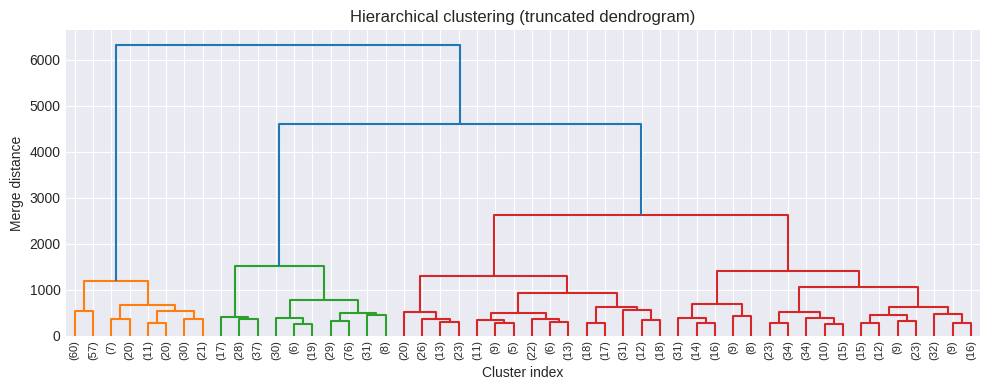

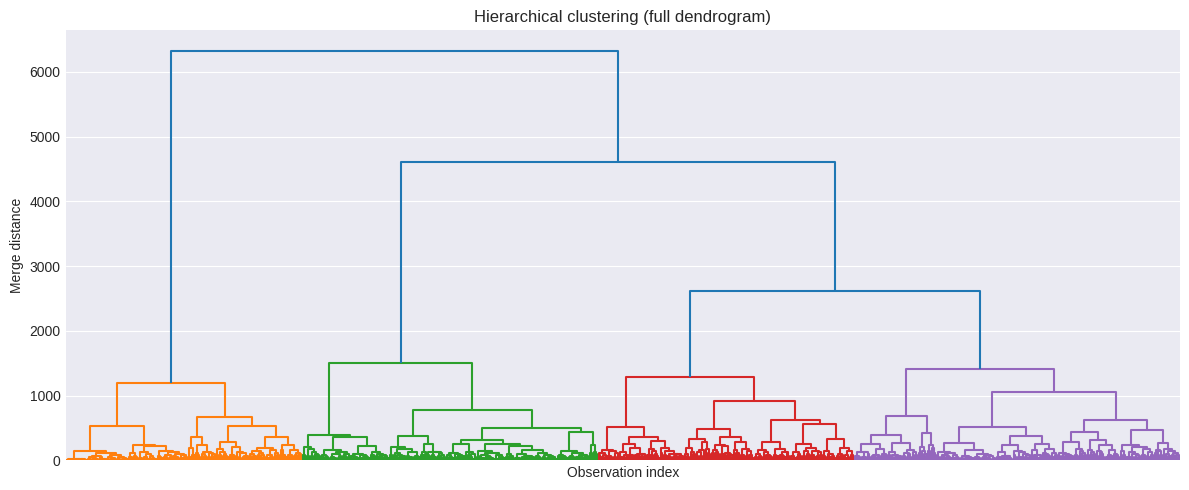

In [6]:
# 7. Hierarchical clustering setup

# 7.2 Compute linkage matrix Z
print("\nComputing linkage matrix with Ward linkage and Euclidean distance...")
Z = sch.linkage(X_level, method="ward", metric="euclidean")

print("Linkage matrix shape:", Z.shape)

# 7.3 Dendrogram visualisation

# Truncated dendrogram: only the last part of the tree
plt.figure(figsize=(10, 4))
sch.dendrogram(Z, truncate_mode="lastp", p=50, leaf_rotation=90)
plt.title("Hierarchical clustering (truncated dendrogram)")
plt.xlabel("Cluster index")
plt.ylabel("Merge distance")
plt.tight_layout()
plt.show()

# Full dendrogram with color threshold
plt.figure(figsize=(12, 5))
max_dist = Z[:, 2].max()
color_threshold = 0.4 * max_dist

sch.dendrogram(
    Z,
    no_labels=True,
    color_threshold=color_threshold,
)
plt.title("Hierarchical clustering (full dendrogram)")
plt.xlabel("Observation index")
plt.ylabel("Merge distance")
plt.tight_layout()
plt.show()


## 8. Determining the number of clusters

To choose a suitable number of clusters we inspect how the merge distances increase when clusters are joined.

### 8.1 Extract merge distances

- The third column of the linkage matrix `Z` contains the merge distances.  
- We focus on the last merges where the number of clusters becomes small.

### 8.2 Elbow style plot

- Plot the merge distance against the number of clusters that remain at each step.  
- Look for an elbow where the merge distance starts to increase sharply.

### 8.3 Acceleration plot

- Reverse the order of merge distances and compute the first difference.  
- This highlights where the merge distance jumps most strongly.  
- Peaks in this plot indicate promising values for the number of clusters.

### 8.4 Candidate cluster counts

- Based on these plots we derive a small set of candidate cluster counts `candidate_ks`.  
- These values will be used for the actual cluster assignment.


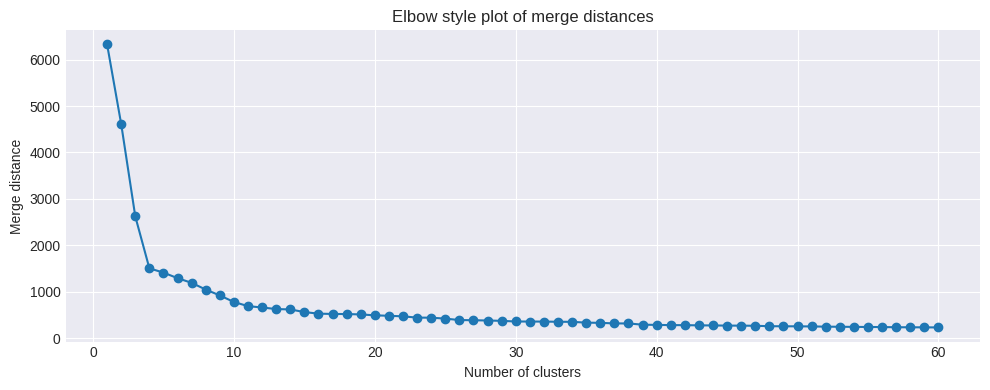

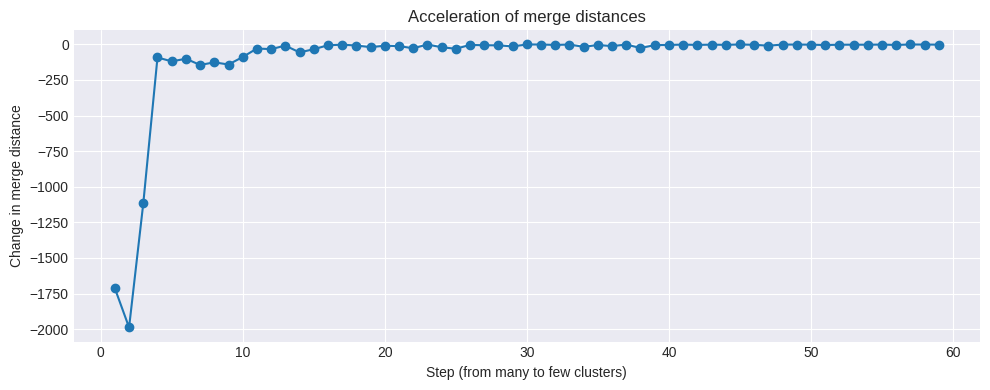


Candidate numbers of clusters to inspect further: [3, 4, 5, 6, 7]


In [7]:
# 8. Determining the number of clusters

merge_distances = Z[:, 2]
n_merges = merge_distances.shape[0]

# We focus on the last N_LAST merges (where the cluster count is small)
N_LAST = min(60, n_merges)

last_distances = merge_distances[-N_LAST:]
# Number of clusters remaining before each of the last merges
clusters_remaining = np.arange(N_LAST, 0, -1)

# 8.2 Elbow style plot
plt.figure()
plt.plot(clusters_remaining, last_distances, marker="o")
plt.title("Elbow style plot of merge distances")
plt.xlabel("Number of clusters")
plt.ylabel("Merge distance")
plt.tight_layout()
plt.show()

# 8.3 Acceleration plot
rev_distances = last_distances[::-1]
acceleration = np.diff(rev_distances)

plt.figure()
plt.plot(np.arange(1, acceleration.shape[0] + 1), acceleration, marker="o")
plt.title("Acceleration of merge distances")
plt.xlabel("Step (from many to few clusters)")
plt.ylabel("Change in merge distance")
plt.tight_layout()
plt.show()

# 8.4 Candidate cluster counts
candidate_ks = [3, 4, 5, 6, 7]
print("\nCandidate numbers of clusters to inspect further:", candidate_ks)


## 9. Cluster assignment for candidate values of k

We now cut the hierarchical tree at several candidate numbers of clusters and inspect the resulting cluster sizes.

### 9.1 Assign cluster labels with `fcluster`

- For each `k` in `candidate_ks` we use `scipy.cluster.hierarchy.fcluster` to assign cluster labels.  
- Cluster labels are stored in new columns `cluster_k3`, `cluster_k4`, `cluster_k5`, etc.

### 9.2 Cluster size tables

- For each `k` we show a frequency table of cluster labels.  
- This helps to spot very small or very large clusters.

### 9.3 Selection of focus `k`

- Based on visual inspection and the size tables we choose a focus value `k_focus` for further analysis.


In [8]:
# 9. Cluster assignment for candidate values of k

cluster_columns = []

for k in candidate_ks:
    col_name = f"cluster_k{k}"
    es_df[col_name] = fcluster(Z, t=k, criterion="maxclust")
    cluster_columns.append(col_name)

    print(f"\nCluster size distribution for k = {k}:")
    print(es_df[col_name].value_counts().sort_index())

print("\nCluster columns added to es_df:")
print(cluster_columns)

# 9.3 Choose one k for detailed analysis
k_focus = 3
cluster_col = f"cluster_k{k_focus}"

if cluster_col not in es_df.columns:
    raise KeyError(
        f"Column '{cluster_col}' not found. "
        f"Make sure k_focus is in candidate_ks."
    )

print(f"\nUsing k_focus = {k_focus} with column '{cluster_col}' for further analysis.")



Cluster size distribution for k = 3:
cluster_k3
1    226
2    281
3    554
Name: count, dtype: int64

Cluster size distribution for k = 4:
cluster_k4
1    226
2    281
3    244
4    310
Name: count, dtype: int64

Cluster size distribution for k = 5:
cluster_k5
1    226
2     82
3    199
4    244
5    310
Name: count, dtype: int64

Cluster size distribution for k = 6:
cluster_k6
1    226
2     82
3    199
4    244
5     78
6    232
Name: count, dtype: int64

Cluster size distribution for k = 7:
cluster_k7
1    226
2     82
3    199
4     82
5    162
6     78
7    232
Name: count, dtype: int64

Cluster columns added to es_df:
['cluster_k3', 'cluster_k4', 'cluster_k5', 'cluster_k6', 'cluster_k7']

Using k_focus = 3 with column 'cluster_k3' for further analysis.


## 10. Cluster centroid analysis

We now analyse the typical daily price profile for each cluster.

### 10.1 Compute cluster centroids

- For the focus clustering `k_focus` we group by the cluster label.  
- For each cluster we compute the mean of each hourly price column.  
- This yields a 24 dimensional centroid for each cluster.

### 10.2 Plot daily profiles of cluster centroids

- Plot all centroid profiles in a single figure.  
- The x axis shows the hour of the day, the y axis the price level.  
- Each line corresponds to one cluster.

### 10.3 Interpretation

- The centroid plots help to interpret cluster characteristics, for example:
  - flat profiles  
  - strong evening peaks  
  - high midday prices



Cluster centroids (first rows):


,h00,h01,h02,h03,h04,h05,h06,h07,h08,h09,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
cluster_k3,,,,,,,,,,,,,,,,,,,,,
1,25.154425,19.018938,16.256195,14.579115,13.605841,15.099027,19.682743,28.178274,24.962876,14.315487,...,2.097345,2.083230,3.337389,6.811460,13.566947,27.114735,43.333451,53.227876,44.498673,33.430442
2,118.631922,112.526299,108.266228,106.313630,105.156085,108.431815,118.310320,131.243594,137.545053,125.887580,...,94.213630,95.060712,102.037580,115.205018,130.458149,143.435480,148.427687,143.462349,133.337616,123.473843
3,86.882437,79.500289,75.368502,72.720866,71.004458,73.664404,81.793051,93.312022,90.889874,70.701390,...,31.541986,30.707581,36.638718,50.512599,68.579856,92.438682,108.978394,112.414603,103.272798,92.185668


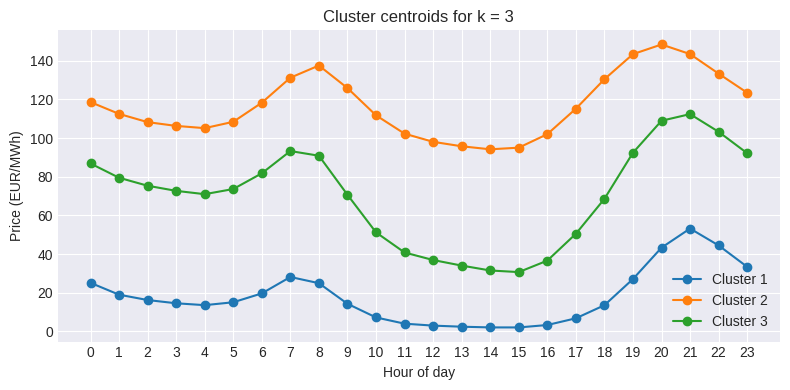

In [9]:
# 10. Cluster centroid analysis

# 10.1 Compute cluster centroids
centroids = (
    es_df
    .groupby(cluster_col)[hour_cols_sorted]
    .mean()
    .sort_index()
)

print("\nCluster centroids (first rows):")
display(centroids.head())

# Build a consistent colour map for all plots for this k_focus
unique_clusters = centroids.index.to_numpy()
n_clusters = unique_clusters.shape[0]

base_cmap = plt.get_cmap("tab10")
cluster_colors = {
    cluster_id: base_cmap(i % base_cmap.N)
    for i, cluster_id in enumerate(unique_clusters)
}

# 10.2 Plot daily profiles of cluster centroids
hours = np.arange(24)

plt.figure(figsize=(8, 4))
for cluster_id, row in centroids.iterrows():
    plt.plot(
        hours,
        row.values,
        marker="o",
        label=f"Cluster {cluster_id}",
        color=cluster_colors[cluster_id],
    )

plt.xticks(hours)
plt.xlabel("Hour of day")
plt.ylabel("Price (EUR/MWh)")
plt.title(f"Cluster centroids for k = {k_focus}")
plt.legend()
plt.tight_layout()
plt.show()


## 11. Calendar based visualisation of cluster regimes

To understand how cluster regimes evolve over the calendar we create a year by year calendar plot.

### 11.1 Add calendar fields

- Derive:
  - `year`  
  - `day_of_year`  
  - `weekday` (0 = Monday, 6 = Sunday)  
  - `week_index` as a simple week counter starting at zero.

### 11.2 Build discrete colour map for clusters

- Use a qualitative colour map (for example `tab10`).  
- Map each cluster label to a distinct colour.  
- Handle missing values as white.

### 11.3 Function to plot a single year calendar

- For a given year and cluster column:
  - Create a matrix with rows as calendar weeks and columns as weekdays.  
  - Fill the matrix with cluster labels.  
  - Plot it with `imshow` using the discrete colour map.  
  - Add axis labels and numeric cluster labels inside each cell.

### 11.4 Loop over years

- For each year present in the data create one calendar plot.  
- This shows how cluster regimes change over years and seasons.



Plotting cluster calendar for year 2023...


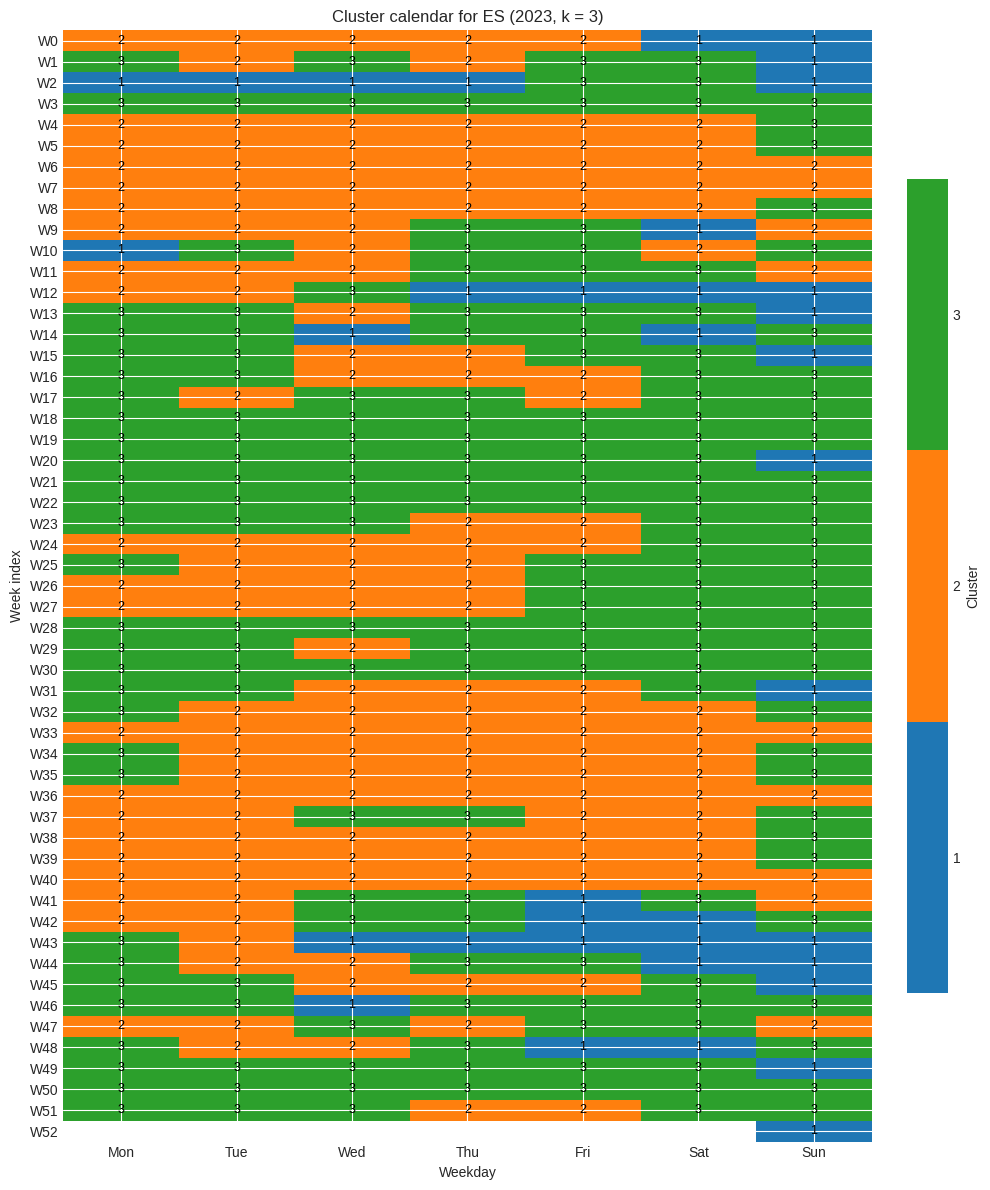


Plotting cluster calendar for year 2024...


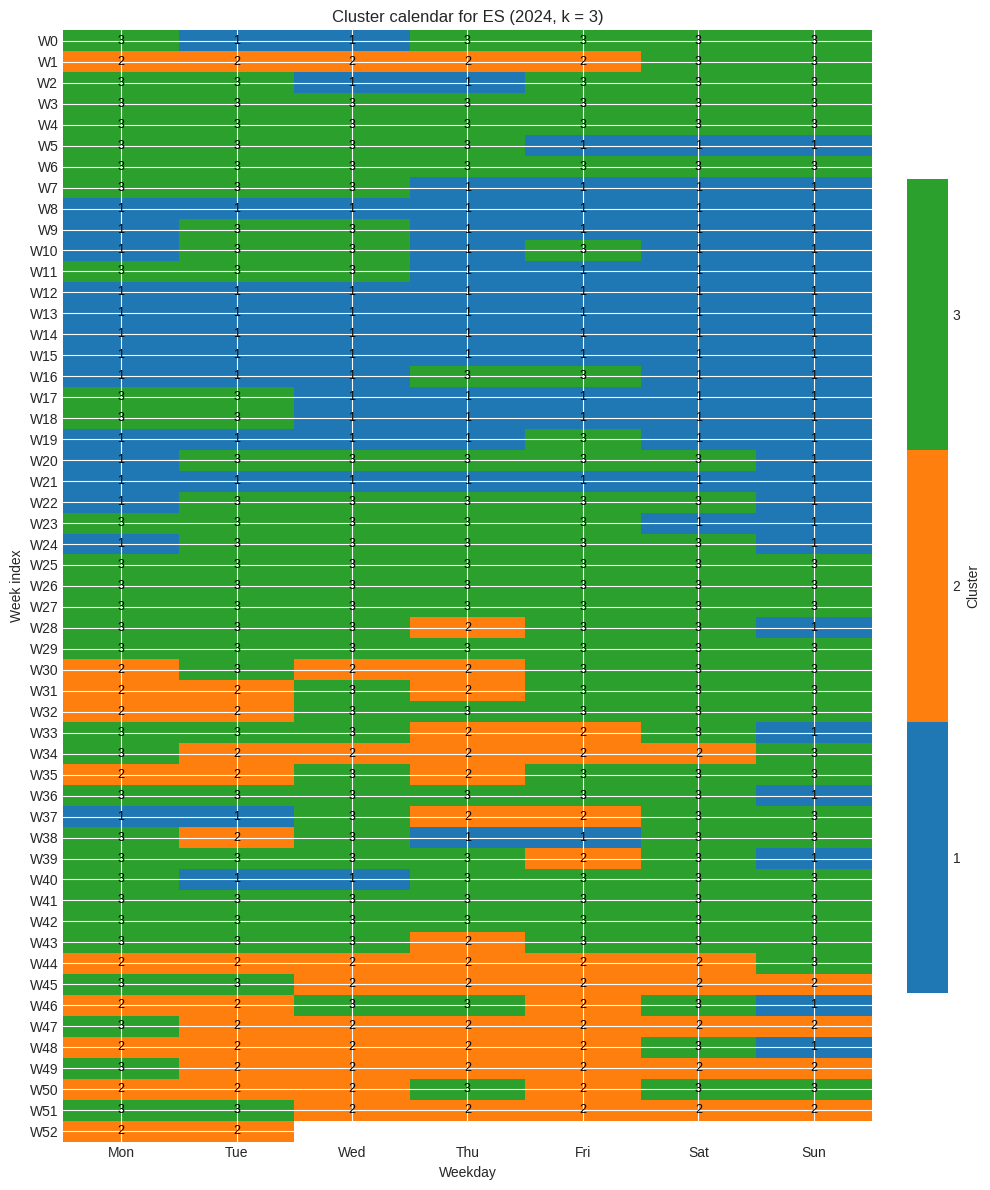


Plotting cluster calendar for year 2025...


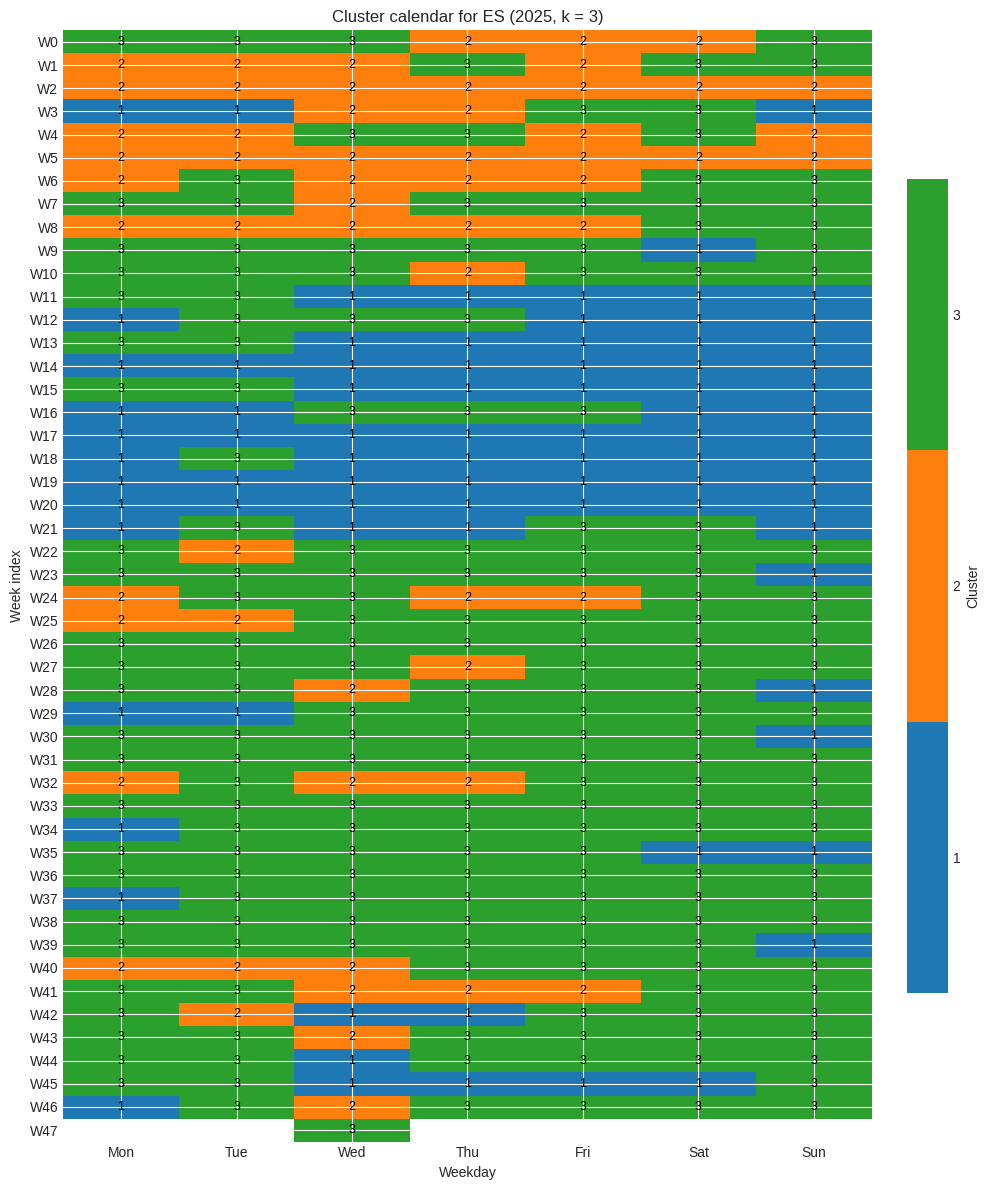

In [10]:
# 11. Calendar based visualisation of cluster regimes

# 11.1 Add calendar fields
es_df["year"] = es_df["date"].dt.year
es_df["day_of_year"] = es_df["date"].dt.dayofyear
es_df["weekday"] = es_df["date"].dt.weekday  # Monday = 0, Sunday = 6
es_df["week_index"] = (es_df["day_of_year"] - 1) // 7

# 11.2 Build discrete colour map for clusters
unique_clusters = np.sort(es_df[cluster_col].unique())
n_clusters = unique_clusters.shape[0]

# Use the same colours as in the centroid plot, if available
try:
    color_list = [cluster_colors[cl] for cl in unique_clusters]
except NameError:
    base_cmap = plt.get_cmap("tab10")
    color_list = [base_cmap(i % base_cmap.N) for i in range(n_clusters)]

cluster_cmap = ListedColormap(color_list)
cluster_cmap.set_bad("white")

bounds = np.arange(0.5, n_clusters + 1.5, 1)
norm = BoundaryNorm(bounds, cluster_cmap.N)

cluster_to_idx = {cl: idx + 1 for idx, cl in enumerate(unique_clusters)}


def plot_cluster_calendar_for_year(df_year, year, cluster_col, cmap, norm):
    """
    Plot a calendar style heatmap of cluster assignments for one year.
    """

    # Rows: simple week index starting at zero.
    # Columns: weekday (0 = Monday, 6 = Sunday).
    max_week_index = df_year["week_index"].max()
    n_weeks = max_week_index + 1
    n_weekdays = 7

    calendar_mat = np.full((n_weeks, n_weekdays), np.nan)

    for _, row in df_year.iterrows():
        w = int(row["week_index"])
        d = int(row["weekday"])
        calendar_mat[w, d] = cluster_to_idx[row[cluster_col]]

    # Bigger figure so individual cells are easier to see
    plt.figure(figsize=(10, 12))
    im = plt.imshow(calendar_mat, aspect="auto", cmap=cmap, norm=norm)

    # Write cluster labels into each non-missing cell
    for w in range(n_weeks):
        for d in range(n_weekdays):
            value = calendar_mat[w, d]
            if not np.isnan(value):
                cluster_label = unique_clusters[int(value) - 1]
                plt.text(
                    d,
                    w,
                    str(cluster_label),
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="black",
                )

    plt.yticks(
        ticks=np.arange(n_weeks),
        labels=[f"W{w}" for w in range(n_weeks)],
    )
    plt.xticks(
        ticks=np.arange(n_weekdays),
        labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    )

    plt.title(f"Cluster calendar for ES ({year}, k = {k_focus})")
    plt.xlabel("Weekday")
    plt.ylabel("Week index")

    # Cleaner colorbar: ticks exactly at the cluster IDs
    cbar = plt.colorbar(
        im,
        boundaries=bounds,
        ticks=np.arange(1, n_clusters + 1),
        fraction=0.046,
        pad=0.04,
        spacing="proportional",
    )
    cbar.set_label("Cluster")
    cbar.set_ticklabels([str(cl) for cl in unique_clusters])

    plt.tight_layout()
    plt.show()


# 11.4 Loop over years

for year in sorted(es_df["year"].unique()):
    df_year = es_df[es_df["year"] == year]
    print(f"\nPlotting cluster calendar for year {year}...")
    plot_cluster_calendar_for_year(
        df_year=df_year,
        year=year,
        cluster_col=cluster_col,
        cmap=cluster_cmap,
        norm=norm,
    )


## 12. Wrap up and next steps

### 12.1 Summary of main findings

- The ES daily price profiles can be clustered into a small number of typical regimes.  
- The centroid plots show the characteristic shapes of these regimes, for example high peak hours or flatter profiles.  
- The calendar view reveals how these regimes appear across weeks and seasons.

### 12.2 Limitations

- We cluster raw price levels without normalisation. This means that both shape and absolute level drive the clusters.  
- The choice of `k_focus` is based on visual inspection of the dendrogram and merge distances. It is not fully automated.  
- Extreme days are kept in the sample and may influence cluster centroids.

### 12.3 Possible extensions

- Normalise daily profiles, for example by subtracting the daily mean, in order to focus purely on shape.  
- Run separate clusterings for different time periods and compare the stability of cluster regimes.  
- Evaluate how well the clusters explain variance in prices or other KPIs, for example balancing costs.


In [11]:
# Export date -> cluster mapping (ES)
df_out = es_df.copy()
if "date" not in df_out.columns:
    df_out = df_out.reset_index()

df_out = df_out[["date", cluster_col]].rename(columns={cluster_col: "cluster"})
df_out.to_csv("ES_date_cluster.csv", index=False)
